In [25]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [26]:
# Import dataset
df = pd.read_csv("./dataset.csv")
df_original_valence = df["valence"]

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# Scalar
scalar = StandardScaler()

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence"], axis=1)
y = df["valence"]

# Normalize data
X = pd.DataFrame(scalar.fit_transform(X), columns=X.columns)

# Get a random number for the random_state variable
import random

random_state = random.randint(1, 100)

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

# print(df.head(1))

# target_train.head()
# # attr_train.head()
# target_test.head()

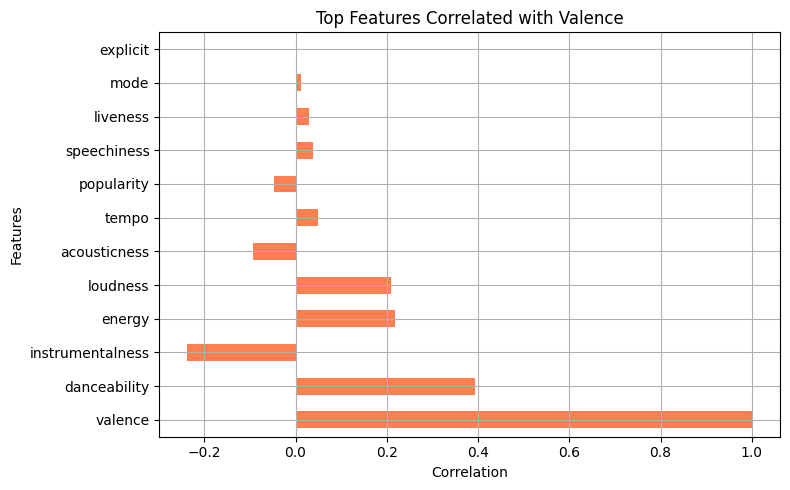

In [27]:
### Features correlating with Valence ###
# df = pd.read_csv("./dataset.csv")

corr_df = df.drop(
    columns=["track_id", "artists", "album_name", "track_name", "duration_ms"],
    errors="ignore",
)
numeric_df = corr_df.select_dtypes(include="number")

corr_matrix = numeric_df.corr()["valence"]

# Get top 10 positively or negatively correlated features
top_valence_corr = corr_matrix.abs().sort_values(ascending=False).head(20)
top_valence_corr = corr_matrix[top_valence_corr.index]  # preserve sign

# Plot bar chart
plt.figure(figsize=(8, 5))
top_valence_corr.plot(kind="barh", color="coral")
plt.title("Top Features Correlated with Valence")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

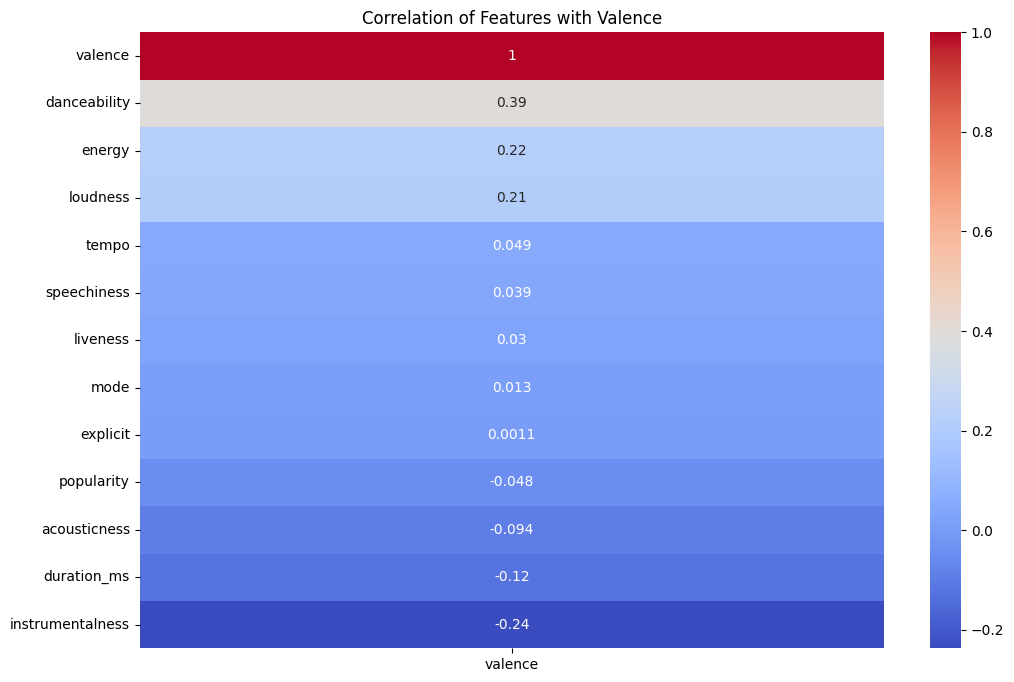

In [28]:
# Remove non-numeric columns
numeric_df = df.select_dtypes(include="number")

# Correlation matrix
corr = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr[["valence"]].sort_values(by="valence", ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation of Features with Valence")
plt.show()

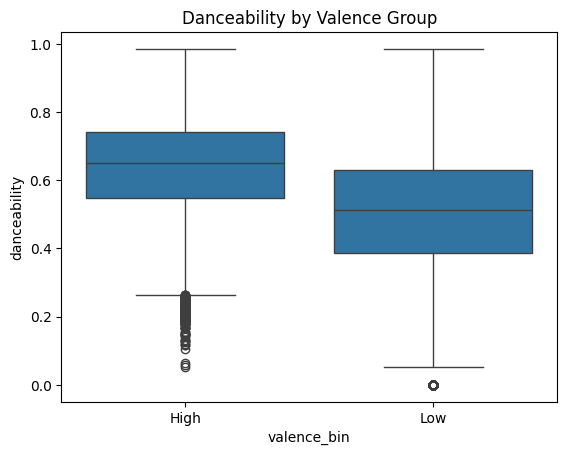

In [29]:
df["valence_bin"] = df["valence"].apply(lambda x: "High" if x > 0.5 else "Low")
sns.boxplot(x="valence_bin", y="danceability", data=df)
plt.title("Danceability by Valence Group")
plt.show()

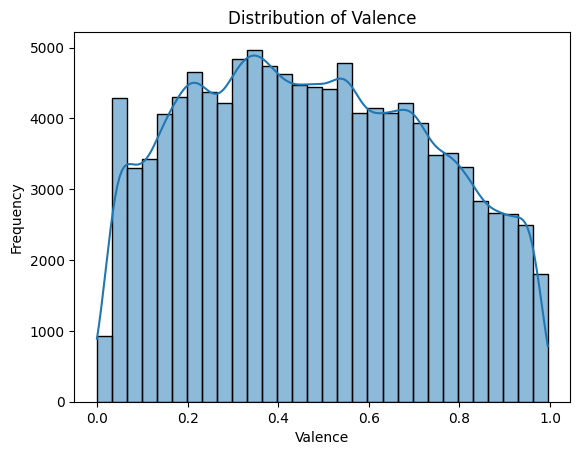

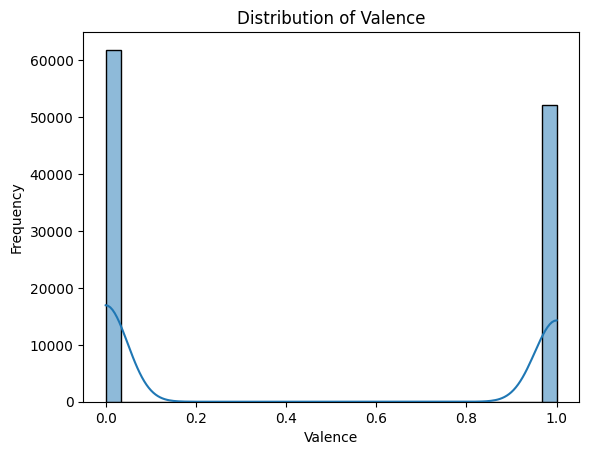

In [32]:
sns.histplot(df_original_valence, kde=True, bins=30)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df["valence"], kde=True, bins=30)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

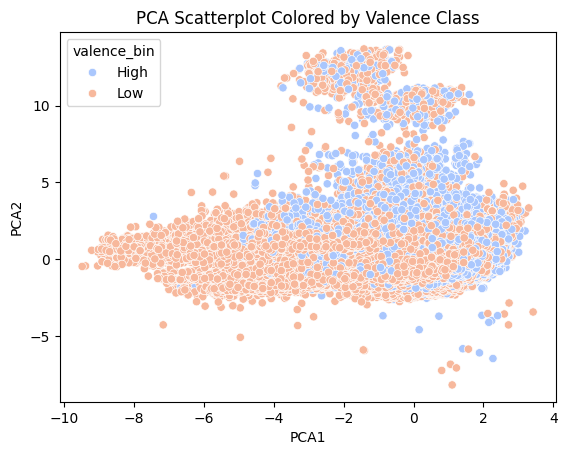

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = df.drop(
    columns=[
        "valence",
        "valence_bin",
        "track_id",
        "track_name",
        "artists",
        "album_name",
    ]
)
X_scaled = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

sns.scatterplot(x="PCA1", y="PCA2", hue="valence_bin", palette="coolwarm", data=df)
plt.title("PCA Scatterplot Colored by Valence Class")
plt.show()